In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('/Users/yuxuan/Documents/Research_module/krumholz-despotic-5aaa9bbb6024')

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
from despotic import cloud

In [4]:
# Start with a Milky Way GMC; set dust temperature to 10 K
gmc = cloud(os.path.join('/Users/yuxuan/Documents/Research_module/krumholz-despotic-5aaa9bbb6024/cloudfiles/MilkyWayGMC.desp'))
gmc.Td = 10.0
gmc.rad.TradDust = 10.0

In [5]:
# Parameters for variable temperature case
gmc.nH = 1000.
gmc.NH = 1.0e23
gmc.rad.chi = 10.0
gmc.rad.ionRate = 1.0e-16

In [12]:
# Define grids in density and velocity gradient
lognH = np.linspace(0,10,100)
logdVdr = np.linspace(-3,3,75)

# We choose CO 1-0,4-3; C18O 1-0,4-3; pNH3 (1,1); HCN 1-0 with hyperfine splitting; N2H+ 1-0 with hfs(hyperfinespliting) 
# transition=[np.array([3]), np.array(1)] for N2H+(with hfs) 
# transition=[np.array([4]), np.array(3)] for the 4-3 species 
# transition=[np.array([1]), np.array(0)] for HCN(with hfs) and the rest of tracers 

directory = '/Users/yuxuan/Desktop/molecule'
sp1 = 'hcn' # emitter name in Capital form (except hcn)
sp2 = 'hcn' # detailed name
path = '%s/HCN'%(directory)
transition = [np.array([1]), np.array([0])]
# em_url = 'https://home.strw.leidnuniv.nl/~moldata/datafiles/p-nh3.dat'  # used for pnh3
em_url = 'http://home.strw.leidenuniv.nl/~moldata/datafiles/hcn@hfs.dat'  # used for hcn
# em_url = 'http://www.strw.leidenuniv.nl/~moldata/datafiles/n2h+_hfs.dat' # used for n2h+
# em_file = 'LAMDA/n2h+_hfs.dat'
# other line don't need to specify em_url or em_file explicitly.



# emitter abundances and gas temperatures to use
# CO 1.0e-4
# C18O 1.0e-7
# pNH3 1.0e-8
# HCN 1.0e-8
# N2H+ 1.0e-10
x = [1.0e-8]
Tgval = [ 10.]
labels = ['std']

lum_tab = 1 # generate luminosity tabel
thin = 1; # 0:include opacity effect; 1: neglect opacity effect
tau_tab = 0  # generate opacity table

In [13]:
# Generate lum tables for constant temperature cases
for i, x_, Tgval_, lab in zip(range(len(x)), x, Tgval, labels):
    
    # Print status
    if lum_tab == True:
        print("Generating {:s}{:s}_lum_{:s}.txt for x = {:e}, Tg = {:f}"
              .format(sp2, '_thin'*thin , lab, x_, Tgval_))
    elif tau_tab == True:
        print("Generating {:s}_tau_{:s}.txt for x = {:e}, Tg = {:f}"
              .format(sp2,lab, x_, Tgval_))
    # Set abundance and gas temperature
    if sp1=='N2H+' or sp1=='pNH3' or sp1=='hcn':
        gmc.addEmitter(sp1, x_, emitterURL = em_url)
    else:
        gmc.addEmitter(sp1, x_)
    
    
    gmc.Tg = Tgval_
    
    # Compute luminosity on grid
    logq = []
    for lognH_ in lognH:
        gmc.nH = 10.**lognH_
        logq1 = []
        for logdVdr_ in logdVdr:
            gmc.dVdr = 10.**logdVdr_ * 1.0e5 / 3.09e18
            if lum_tab == True:
                # luminosity
                q = gmc.lineLum(sp1, escapeProbGeom='LVG', lumOnly=True, thin=thin,
                                transition=transition)[0]
            elif tau_tab == True:
                # get optical depth
                q = gmc.lineLum(sp1, escapeProbGeom='LVG', transition = transition)[0]['tau']
            logq1.append(np.log10(q))
        logq.append(logq1)
    logq = np.array(logq)
    
    # Save outputs
    if i == 0:
        np.savetxt('n.txt', lognH)
        np.savetxt('dvdr.txt', logdVdr)
    if lum_tab == True and thin == 0:
        np.savetxt('%s/%s_lum_%s.txt'%(path,sp2,lab), logq)
    elif lum_tab == True and thin == 1:
        np.savetxt('%s/%s_thin_lum_%s.txt'%(path,sp2,lab), logq)
    elif tau_tab == True:
        np.savetxt('%s/%s_tau_%s.txt'%(path,sp2,lab), logq)

Generating hcn_thin_lum_std.txt for x = 1.000000e-08, Tg = 10.000000


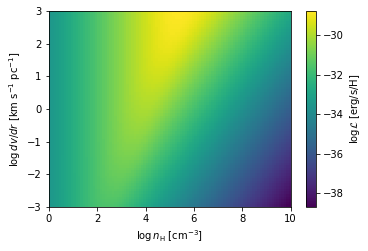

In [14]:
lab='std'
lum_H = np.loadtxt( '%s/%s_lum_%s.txt'%(path,sp2,lab) )
plt.imshow(np.transpose(lum_H), aspect='auto', origin='lower',
           extent=(lognH[0], lognH[-1], logdVdr[0], logdVdr[-1]))
           #vmin=5, vmax=35)
plt.xlabel(r'$\log\,n_{\mathrm{H}}$ [cm$^{-3}$]')
plt.ylabel(r'$\log\,dv/dr$ [km s$^{-1}$ pc$^{-1}$]')
plt.colorbar(label=r'$\log \mathcal{L}$ [erg/s/H]')
plt.subplots_adjust(bottom=0.2,left=0.2)

In [7]:
# Generate luminosities for variable temperature case

# Set abundance to standard value
gmc.addEmitter('HCN', xHCN[1])

# Adjust damping factors and tolerances, since for small dV/dr
# convergence gets difficult; these settings allow a larger
# than normal number of iterations to reach convergence, and
# define convergence a bit more loosely (change below 10^-4
# compared to default of 10^-6)
gmc.dampFactor = 0.25
gmc.maxIter = 1000
gmc.relTol = 1.0e-4
gmc.noWarn = True

# Set dust temperature to equilibrium; this doesn't vary enough
# that it's worth recalculating, so just fix it once and for all
gmc.setDustTempEq()

# Guess initial gas tempeature of 10 K for first iteration
gmc.Tg = 10.0

# Compute luminosity on grid
loglum = []
Tg = []
for i, lognH_ in enumerate(lognH):
    # Print status
    print("Iteration {:d}/{:d}...".format(i+1, len(lognH)))
    
    # Prepare for next density
    gmc.nH = 10.**lognH_
    loglum1 = []
    Tg1 = []
    
    # Loop over dVdr
    for j, logdVdr_ in enumerate(logdVdr):
        
        # Speed up convergence by using guess at this dVdr
        # and previous density as initial guess
        if j == 0 and i != 0:
            gmc.Tg = Tg[-1][-1]
        
        # Get gas temperature and line luminosity
        gmc.dVdr = 10.**logdVdr_ * 1.0e5 / 3.09e18
        gmc.setGasTempEq(escapeProbGeom='LVG')
        l = gmc.lineLum('HCN', escapeProbGeom='LVG', lumOnly=True, 
                        transition=[np.array([1]), np.array(0)])[0]
        
        # Save state
        loglum1.append(np.log10(l))
        Tg1.append(gmc.Tg)
        
    # Append to storage
    loglum.append(loglum1)
    Tg.append(Tg1)
    
    # Save results as we go along
    np.savetxt('hcn_lum_Tvar.txt', np.asarray(loglum))
    np.savetxt('hcn_Tg_Tvar.txt', np.asarray(Tg))

# Convert to array
loglum = np.array(loglum)
Tg = np.array(Tg)

Iteration 1/200...
Iteration 2/200...
Iteration 3/200...
Iteration 4/200...
Iteration 5/200...
Iteration 6/200...
Iteration 7/200...
Iteration 8/200...
Iteration 9/200...
Iteration 10/200...
Iteration 11/200...
Iteration 12/200...
Iteration 13/200...
Iteration 14/200...
Iteration 15/200...
Iteration 16/200...
Iteration 17/200...
Iteration 18/200...
Iteration 19/200...
Iteration 20/200...
Iteration 21/200...
Iteration 22/200...
Iteration 23/200...
Iteration 24/200...
Iteration 25/200...
Iteration 26/200...
Iteration 27/200...
Iteration 28/200...
Iteration 29/200...
Iteration 30/200...
Iteration 31/200...
Iteration 32/200...
Iteration 33/200...
Iteration 34/200...
Iteration 35/200...
Iteration 36/200...
Iteration 37/200...


despotic/emitter.py:953: RuntimeWarning: invalid value encountered in less
  self.levPop[self.levPop < small] = small
despotic/emitter.py:957: RuntimeWarning: invalid value encountered in maximum
  relResid = resid / np.maximum(levPopOld, self.levPop)
despotic/emitter.py:683: RuntimeWarning: invalid value encountered in greater
  idx = tau > 1e-6
despotic/emitter.py:686: RuntimeWarning: invalid value encountered in less_equal
  idx = tau <= 1e-6


Iteration 38/200...
Iteration 39/200...
Iteration 40/200...
Iteration 41/200...
Iteration 42/200...
Iteration 43/200...
Iteration 44/200...
Iteration 45/200...
Iteration 46/200...
Iteration 47/200...
Iteration 48/200...
Iteration 49/200...
Iteration 50/200...
Iteration 51/200...
Iteration 52/200...
Iteration 53/200...
Iteration 54/200...
Iteration 55/200...
Iteration 56/200...
Iteration 57/200...
Iteration 58/200...
Iteration 59/200...
Iteration 60/200...
Iteration 61/200...
Iteration 62/200...
Iteration 63/200...
Iteration 64/200...
Iteration 65/200...
Iteration 66/200...
Iteration 67/200...
Iteration 68/200...
Iteration 69/200...
Iteration 70/200...
Iteration 71/200...
Iteration 72/200...
Iteration 73/200...
Iteration 74/200...
Iteration 75/200...
Iteration 76/200...
Iteration 77/200...
Iteration 78/200...
Iteration 79/200...
Iteration 80/200...
Iteration 81/200...
Iteration 82/200...
Iteration 83/200...
Iteration 84/200...
Iteration 85/200...
Iteration 86/200...
Iteration 87/200...


In [103]:
# Fix up a few non-converged cells; these are sharp local minima in Tg
loglum1 = np.copy(loglum)
Tg1 = np.copy(Tg)
idx = np.where(
    np.logical_and(Tg[1:-1,:] < 0.95*Tg[:-2,:],
                   Tg[1:-1,:] < 0.95*Tg[2:,:]))
print("Fixing {:d} bad cells".format(len(idx[0])))
for i_,j in zip(idx[0],idx[1]):
    i=i_+1
    Tg1[i,j] = 0.5*(Tg1[i-1,j]+Tg1[i+1,j])
    loglum1[i,j] = 0.5*(loglum1[i-1,j]+loglum1[i+1,j])

Fixing 19 bad cells


In [104]:
# Save final results
np.savetxt('hcn_lum_Tvar.txt', np.asarray(loglum1))
np.savetxt('hcn_Tg_Tvar.txt', np.asarray(Tg1))

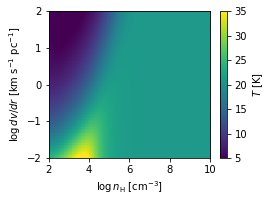

In [102]:
# Save temperature plot
plt.figure(1, figsize=(4,3))
plt.imshow(np.transpose(Tg1), aspect='auto', origin='lower',
           extent=(lognH[0], lognH[-1], logdVdr[0], logdVdr[-1]),
           vmin=5, vmax=35)
plt.xlabel(r'$\log\,n_{\mathrm{H}}$ [cm$^{-3}$]')
plt.ylabel(r'$\log\,dv/dr$ [km s$^{-1}$ pc$^{-1}$]')
plt.colorbar(label=r'$T$ [K]')
plt.subplots_adjust(bottom=0.2,left=0.2)
plt.savefig('tempmap.pdf')